# Training siamese neural net

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import multiprocessing as mp
import itertools
import plotly.express as px
from scipy.stats import entropy
from functools import partial
import re
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset, DataLoader
import random
from matplotlib.colors import ListedColormap
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import torch.nn.functional as F

cuda


## Data

In [174]:
# os.chdir("/data/jake/csci_7000-final_project")
os.chdir('/home/jake/ghub/csci-7000-006-neurosymbolic-nlp')

In [2]:
df_1kg = pd.read_csv("1kg-g2g_vecs.tsv",sep="\t", index_col=0)
df_pcawg = pd.read_csv("pcawg-g2g_vecs.tsv",sep="\t", index_col=0)
df_global = pd.concat([df_1kg, df_pcawg])
print(df_global.shape)
df_global.head()

(2677, 18721)


ACYP2-AFF3  ACYP2-AGAP1  ACYP2-AP000304.12  ACYP2-APP  \
NA18614           1            1                  1          1   
HG01918           1            1                  1          1   
NA18546           1            1                  1          1   
HG02855           1            1                  1          1   
HG03565           1            1                  1          1   

         ACYP2-ARHGAP15  ACYP2-ARHGAP6  ACYP2-BACH1  ACYP2-CACNA2D3  \
NA18614               1              1            1               1   
HG01918               1              1            1               1   
NA18546               1              1            2               1   
HG02855               1              1            1               1   
HG03565               1              1            1               1   

         ACYP2-CADM2  ACYP2-CCSER1  ...  ZSWIM5-TTC28  ZSWIM5-ULK4  \
NA18614            1             1  ...             1            1   
HG01918            1             1  ...             1            1   
NA18546            1             1  ...             1            1   
HG02855            1             1  ...             1            1   
HG03565            1             1  ...             1            1   

         ZSWIM5-USH2A  ZSWIM5-VAV3  ZSWIM5-WDPCP  ZSWIM5-WWOX  ZSWIM5-ZBTB20  \
NA18614             1            1             1            1              1   
HG01918             1            2             1            1              1   
NA18546             1            1             1            1              1   
HG02855             1            1             1            1              1   
HG03565             1            1             2            1              1   

         ZSWIM5-ZNF385D  ZSWIM5-ZNF536  ZSWIM5-ZRANB3  
NA18614               1              1              1  
HG01918               1              1              2  
NA18546               1              1              1  
HG02855               1              2              1  
HG03565               1              1              1  

[5 rows x 18721 columns]

In [3]:
d_tensor_1kg = torch.load("1kg-g2g-tensors.pt")
d_tensor_1kg

{'NA18614': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG01918': tensor([1, 1, 1,  ..., 1, 1, 2], dtype=torch.int32),
 'NA18546': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG02855': tensor([1, 1, 1,  ..., 1, 2, 1], dtype=torch.int32),
 'HG03565': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA19324': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA20527': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA19107': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG01162': tensor([1, 2, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG02885': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA21126': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG00132': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA20332': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA19087': tensor([1, 1, 1,  ..., 2, 1, 1], dtype=torch.int32),
 'HG02035': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG03785': tensor([1, 1,

In [4]:
# scale to pdist range
for k,v in d_tensor_1kg.items():
    s = torch.sum(v)
    d_tensor_1kg[k] = v/s

In [5]:
# set tensor to float 32
for k,v in d_tensor_1kg.items():
    d_tensor_1kg[k] = v.to(torch.float32)

- Note: the l2 distances are already squared for ground truth: $||s_i - s_j||_{2}^{2}$


In [6]:
df_target_1kg = pd.read_csv("1kg-g2g_l2.tsv", sep="\t")
df_target_1kg.head()

l2      s_i      s_j
0  2099.0  NA18614  HG01918
1  2988.0  NA18614  NA18546
2  1381.0  NA18614  HG02855
3  1468.0  NA18614  HG03565
4  1244.0  NA18614  NA19324

- Q: is it better to scale the target vector or leave as is?
- **If scaled**, make sure to transform the embedding distance computed by the model while computing loss (see MSELoss).

<Axes: >

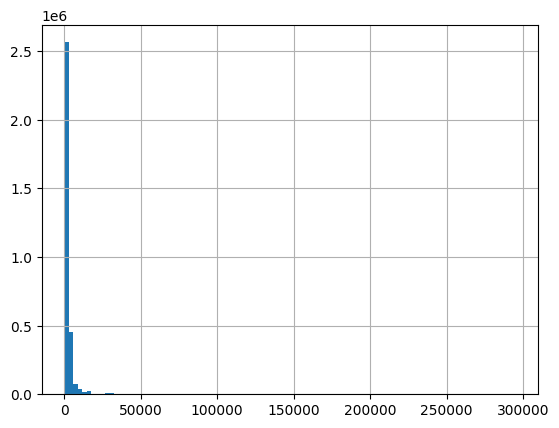

In [8]:
df_target_1kg['l2'].hist(bins=100)

- Note: standard scaler would center the targets around 0, however, I don't think it's straghtforward to z-score nomalize each embedding distance computed during training used to compute loss. There's probably a clever or complex way to do this, but it's out of the scope of this project. 

       l2      s_i      s_j    l2_log
0  2099.0  NA18614  HG01918  7.649693
1  2988.0  NA18614  NA18546  8.002694
2  1381.0  NA18614  HG02855  7.231287
3  1468.0  NA18614  HG03565  7.292337
4  1244.0  NA18614  NA19324  7.126891


<Axes: >

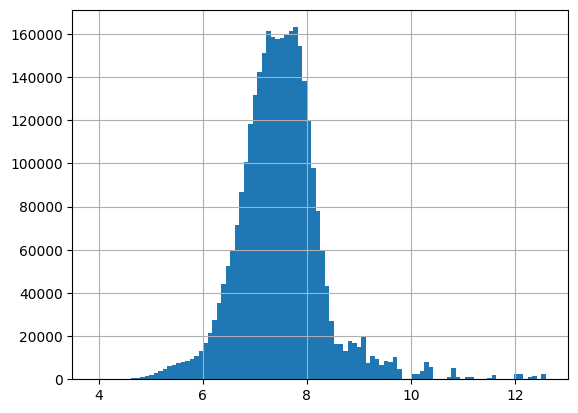

In [9]:
df_target_1kg['l2_log'] = df_target_1kg['l2'].apply(lambda x: np.log(x+1))
# apply standard scaler
# scaler = StandardScaler()
# df_target_1kg['l2_z_log'] = scaler.fit_transform(df_target_1kg['l2_z_log'].values.reshape(-1,1))
# df_target_1kg['l2_z_log'].hist(bins=100)
print(df_target_1kg.head())
df_target_1kg['l2_log'].hist(bins=100)

In [10]:
# metadata retrieved from R package: https://stephenturner.github.io/kgp/
metadata_1kg = pd.read_csv("1kg-metadata.tsv", sep="\t")
metadata_1kg.head()

fid       id pid mid  sex    sexf  pop  reg  \
0  HG00096  HG00096   0   0    1    male  GBR  EUR   
1  HG00097  HG00097   0   0    2  female  GBR  EUR   
2  HG00099  HG00099   0   0    2  female  GBR  EUR   
3  HG00100  HG00100   0   0    2  female  GBR  EUR   
4  HG00101  HG00101   0   0    1    male  GBR  EUR   

                        population  region  
0  British in England and Scotland  Europe  
1  British in England and Scotland  Europe  
2  British in England and Scotland  Europe  
3  British in England and Scotland  Europe  
4  British in England and Scotland  Europe

In [11]:
metadata_1kg['reg'].value_counts()

reg
AFR    661
EAS    504
EUR    503
SAS    489
AMR    347
Name: count, dtype: int64

In [12]:
def lookup_region(sample):
    try:
        return metadata_1kg[metadata_1kg['id'] == sample]['reg'].values[0]
    except IndexError:
        return None
print(lookup_region('HG00096'),
lookup_region('test')
)

EUR None


## Model 1kg

In [13]:
class SiameseDataset(Dataset):
    def __init__(self, d_tensor, df_target, n_samples=1000, scaled_target=True):
        self.d_tensor = d_tensor
        self.df_target = df_target
        # n samples will define the total length of the dataset
        # we could insted use the length of the dataset (which is the number of samples)
        # len(d_tensor), but this is a lot of data per epoch
        # instead, a sampling pairs approach is used
        self.n_samples = n_samples
        self.scaled_target = scaled_target

    def __len__(self):
        return self.n_samples
        # return len(d_tensor.items())

    def __getitem__(self, idx):
        pair = self.df_target.sample(1)
        s1 = pair["s_i"].values[0]
        t1 = self.d_tensor[s1]
        s2 = pair["s_j"].values[0]
        t2 = self.d_tensor[s2]
        if self.scaled_target:
            target = torch.tensor(pair["l2_log"].values[0], dtype=torch.float32)
        else:
            target = torch.tensor(pair["l2"].values[0], dtype=torch.float32)
        return t1, t2, target

- Quick method for hold out

In [160]:
df_target_test = df_target.sample(1000, random_state=0)
# exclude test from train
# df_target_train = df_target[~df_target.index.isin(df_target_test.index)]
# print(len(df_target_train), len(df_target_test), len(df_target))

- Note: A less stringent approach could be employed

It could be allowed that any sample can be seen during training, yet not allowing for an 
exact pair in the test data set to be seen during training.

- However, I'm using the stringent approach of excluding any sample in the test pairs from the training data

In [183]:
test_samples = pd.concat([df_target_test['s_i'], df_target_test['s_j']]).unique()
test_samples.shape

(1395,)

In [184]:
# filter out test samples
df_target_train = df_target[~df_target['s_i'].isin(test_samples) & ~df_target['s_j'].isin(test_samples)]
print(len(df_target_train), len(df_target_test), len(df_target))
# show that the test samples are not in the train set
print(pd.concat([df_target_train['s_i'], df_target_train['s_j']]).nunique(), len(test_samples))
df_target_train.head()

649230 1000 3211845
1140 1395


l2      s_i      s_j    l2_log
0  2099.0  NA18614  HG01918  7.649693
1  2988.0  NA18614  NA18546  8.002694
2  1381.0  NA18614  HG02855  7.231287
3  1468.0  NA18614  HG03565  7.292337
5  1670.0  NA18614  NA20527  7.421178

In [188]:
# no need to subset the tensor dictionary since we sample from the target dataframe
# which is paritioned for training samples only
dataset = SiameseDataset(d_tensor_1kg, df_target_train, n_samples=1000,scaled_target=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

It's a bit confusing since the targets are transformed, but here's another reminder:

- Ground truth targets are squared l2 distances, which can optionally be log transformed.
- Therefore, the model l2 embedding distances need to be transformed by the same methods: squared and optional log.

In [35]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )
    def forward_one(self, x):
        # compute embedding
        return self.fc(x)

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return out1, out2

### MSE Loss

In [37]:
class CustomMSELoss(nn.Module):
    def __init__(self, scaled_target=True):
        super(CustomMSELoss, self).__init__()
        self.scaled_target = scaled_target

    def forward(self, embedding_distance, target_distance):
        # note: the ground truths are *squared* l2 distances
        # this is handled for embedding distance outside of the loss function for now
        
        # if targets are log scaled,
        # also log scaled the embedding distances
        if self.scaled_target:
            embedding_distance = torch.log10(embedding_distance + 1)
            loss = torch.mean((embedding_distance - target_distance) ** 2) # mse
        loss = torch.mean((embedding_distance - target_distance) ** 2)
        return loss

### Triplet loss

In [77]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Normalize the embeddings to unit vectors
        anchor = F.normalize(anchor, p=2, dim=1)
        positive = F.normalize(positive, p=2, dim=1)
        negative = F.normalize(negative, p=2, dim=1)
        
        # Compute cosine similarity
        positive_similarity = F.cosine_similarity(anchor, positive)
        negative_similarity = F.cosine_similarity(anchor, negative)
        
        # Compute cosine distance
        distance_positive = 1 - positive_similarity
        distance_negative = 1 - negative_similarity
        # relu ensures loss is 0
        # since it could be negative if d_pos - d_neg + margin < 0
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        # mean over the batch
        return losses.mean()

### Train

In [205]:
input_dim = d_tensor_1kg["HG00096"].shape[0]
embedding_dim = 512
print(input_dim,embedding_dim)
model = SiameseNetwork(input_dim, embedding_dim)
model.to(device)
criterion = CustomMSELoss(scaled_target=True) # using log scaled l2
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 20

18721 512


In [ ]:
torch.set_num_threads(15) # using gpu, but set this just in case
writer = SummaryWriter(log_dir="logs")
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    l = []
    for i, data in enumerate(dataloader):
        t1, t2, target = data
        t1, t2, target = t1.to(device), t2.to(device), target.to(device)
        # reset grad    
        optimizer.zero_grad()
        output1, output2 = model(t1, t2)
        embedding_distance = torch.sum((output1 - output2) ** 2, dim=1) # squared l2
        loss = criterion(embedding_distance, target)
        loss.backward()
        optimizer.step()
        l.append(loss.item())
        running_loss += loss.item()
        print(f"Epoch {epoch+1}, batch {i+1}, loss: {loss.item()}")
        writer.add_scalar('Loss/train', loss.item(), epoch * len(dataloader) + i)
    print(f"Epoch {epoch+1}, loss: {running_loss}")
writer.close()

Epoch 1, batch 1, loss: 57.111915588378906
Epoch 1, batch 2, loss: 61.00520324707031
Epoch 1, batch 3, loss: 57.372093200683594
Epoch 1, batch 4, loss: 54.97993850708008
Epoch 1, batch 5, loss: 54.21558380126953
Epoch 1, batch 6, loss: 58.90021514892578
Epoch 1, batch 7, loss: 54.97606658935547
Epoch 1, batch 8, loss: 57.40986633300781
Epoch 1, batch 9, loss: 57.511070251464844
Epoch 1, batch 10, loss: 57.78569030761719
Epoch 1, batch 11, loss: 57.799522399902344
Epoch 1, batch 12, loss: 57.142181396484375
Epoch 1, batch 13, loss: 60.017494201660156
Epoch 1, batch 14, loss: 56.27006530761719
Epoch 1, batch 15, loss: 57.81557846069336
Epoch 1, batch 16, loss: 57.027950286865234
Epoch 1, loss: 917.3404350280762
Epoch 2, batch 1, loss: 60.122901916503906
Epoch 2, batch 2, loss: 54.96807861328125
Epoch 2, batch 3, loss: 57.09115219116211
Epoch 2, batch 4, loss: 55.314544677734375
Epoch 2, batch 5, loss: 56.308170318603516
Epoch 2, batch 6, loss: 54.53364181518555
Epoch 2, batch 7, loss: 58

In [ ]:
# ### this contains all code to get a converging model
# # block1
# class SiameseNetwork(nn.Module):
#     def __init__(self, input_dim, embedding_dim):
#         super(SiameseNetwork, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(input_dim, embedding_dim),
#             nn.ReLU(),
#             nn.Linear(embedding_dim, embedding_dim),
#             nn.ReLU(),
#             nn.Linear(embedding_dim, embedding_dim)
#         )
#     def forward_one(self, x):
#         # compute embedding
#         return self.fc(x)

#     def forward(self, x1, x2):
#         out1 = self.forward_one(x1)
#         out2 = self.forward_one(x2)
#         return out1, out2
# # block2
# class CustomMSELoss(nn.Module):
#     def __init__(self, scaled_target=True):
#         super(CustomMSELoss, self).__init__()
#         self.scaled_target = scaled_target

#     def forward(self, embedding_distance, target_distance):
#         # note: the ground truths are *squared* l2 distances
#         # this is handled for embedding distance outside of the loss function for now
        
#         # if targets are log scaled,
#         # also log scaled the embedding distances
#         if self.scaled_target:
#             embedding_distance = torch.log10(embedding_distance + 1)
#             loss = torch.mean((embedding_distance - target_distance) ** 2) # mse
#         loss = torch.mean((embedding_distance - target_distance) ** 2)
#         return loss

# # block3
# input_dim = d_tensor_1kg["HG00096"].shape[0]
# embedding_dim = 512
# print(input_dim,embedding_dim)
# model = SiameseNetwork(input_dim, embedding_dim)
# model.to(device)
# criterion = CustomMSELoss(scaled_target=True) # using log scaled l2
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# n_epochs = 20
# # block4
# torch.set_num_threads(15) # using gpu, but set this just in case
# writer = SummaryWriter(log_dir="logs")
# for epoch in range(n_epochs):
#     model.train()
#     running_loss = 0.0
#     l = []
#     for i, data in enumerate(dataloader):
#         t1, t2, target = data
#         t1, t2, target = t1.to(device), t2.to(device), target.to(device)
#         # reset grad    
#         optimizer.zero_grad()
#         output1, output2 = model(t1, t2)
#         embedding_distance = torch.sum((output1 - output2) ** 2, dim=1) # squared l2
#         loss = criterion(embedding_distance, target)
#         loss.backward()
#         optimizer.step()
#         l.append(loss.item())
#         running_loss += loss.item()
#         print(f"Epoch {epoch+1}, batch {i+1}, loss: {loss.item()}")
#         writer.add_scalar('Loss/train', loss.item(), epoch * len(dataloader) + i)
#     print(f"Epoch {epoch+1}, loss: {running_loss}")
# writer.close()

- Since all test samples were excluded, any combination of test samples can be used for evaluation at inference time
- For practical purposes, choose 1000 pairs ground truth versus predicted

In [207]:
df_target_test = df_target[(df_target['s_i'].isin(test_samples)) & (df_target['s_j'].isin(test_samples))]
print(df_target_test.shape)
df_target_test.head()

(972315, 4)


l2      s_i      s_j    l2_log
12663   739.0  NA19324  HG02885  6.606650
12664  1874.0  NA19324  NA21126  7.536364
12665  1935.0  NA19324  HG00132  7.568379
12668   178.0  NA19324  HG02035  5.187386
12669   211.0  NA19324  HG03785  5.356586

In [208]:
df_target_test_sub = df_target_test.sample(1000, random_state=0)
print(df_target_test_sub.shape)
df_target_test_sub.head()

(1000, 4)


l2      s_i      s_j    l2_log
539629   4587.0  NA19213  NA19431  8.431199
2023457  1780.0  HG00737  HG01843  7.484930
2276963  2391.0  HG02471  HG03108  7.779885
1279172  2511.0  HG02108  NA19378  7.828835
1403012   815.0  NA20778  HG02819  6.704414

In [213]:
# inference on test pairs
ys = []
y_preds = []
model.eval()
for i, row in df_target_test_sub.iterrows():
    s1 = row['s_i']
    s2 = row['s_j']
    t1 = d_tensor_1kg[s1].to(device)
    t2 = d_tensor_1kg[s2].to(device)
    output1, output2 = model(t1, t2)
    embedding_distance = torch.log10(torch.sum((output1 - output2) ** 2) + 1)
    y = row['l2_log']
    y_pred = embedding_distance.item()
    ys.append(y)
    y_preds.append(y_pred)
    print(f"Pair: {s1}, {s2}, target: {row['l2_log']}, distance: {embedding_distance.item()}")

Pair: NA19213, NA19431, target: 8.431199478249262, distance: 4.855306148529053
Pair: HG00737, HG01843, target: 7.484930283289661, distance: 3.2204277515411377
Pair: HG02471, HG03108, target: 7.779885115070522, distance: 4.8011064529418945
Pair: HG02108, NA19378, target: 7.828834527588089, distance: 3.674321413040161
Pair: NA20778, HG02819, target: 6.704414354964107, distance: 3.6424713134765625
Pair: NA12282, NA19436, target: 7.323830566202317, distance: 4.5352349281311035
Pair: HG02582, NA20898, target: 8.256347772918016, distance: 4.991060733795166
Pair: HG00177, HG03730, target: 7.382124365737512, distance: 4.138256072998047
Pair: HG04035, HG01052, target: 7.502738210754851, distance: 4.428689479827881
Pair: NA20344, HG03867, target: 5.493061443340548, distance: 2.279372215270996
Pair: HG03240, HG02339, target: 7.428927194802272, distance: 3.8827974796295166
Pair: HG01776, HG00332, target: 7.214504414151143, distance: 4.548794746398926
Pair: HG02078, HG03873, target: 7.4133673356952

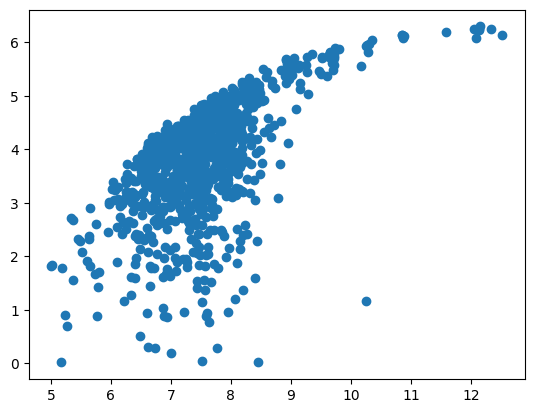

In [214]:
plt.scatter(ys, y_preds)

In [215]:
# inference on train pairs
ys = []
y_preds = []
model.eval()
for i, row in df_target_train.sample(1000).iterrows():
    s1 = row['s_i']
    s2 = row['s_j']
    t1 = d_tensor_1kg[s1].to(device)
    t2 = d_tensor_1kg[s2].to(device)
    output1, output2 = model(t1, t2)
    embedding_distance = torch.log10(torch.sum((output1 - output2) ** 2) + 1)
    y = row['l2_log']
    y_pred = embedding_distance.item()
    ys.append(y)
    y_preds.append(y_pred)
    print(f"Pair: {s1}, {s2}, target: {row['l2_log']}, distance: {embedding_distance.item()}")

Pair: HG03603, NA21124, target: 7.898039690764618, distance: 4.306085109710693
Pair: NA20767, HG00337, target: 8.389814262086407, distance: 2.890347480773926
Pair: HG02496, HG03058, target: 7.913155185928067, distance: 4.671861171722412
Pair: HG03832, NA19247, target: 7.335633981927201, distance: 4.304865837097168
Pair: HG03809, HG02113, target: 6.551080335043404, distance: 3.2678773403167725
Pair: HG02184, NA19058, target: 6.228511003591183, distance: 3.4710607528686523
Pair: HG02131, NA18985, target: 8.40178233990491, distance: 5.062409400939941
Pair: NA19909, HG01863, target: 8.494538500851432, distance: 4.445708751678467
Pair: NA21088, NA19066, target: 10.382512863752321, distance: 5.965264797210693
Pair: HG00736, HG03653, target: 7.058758152518664, distance: 2.7327497005462646
Pair: NA07051, NA19719, target: 9.44375103564617, distance: 4.871711254119873
Pair: HG01354, HG02882, target: 7.67368812926773, distance: 3.5733563899993896
Pair: HG01384, NA20897, target: 7.065613363597717,

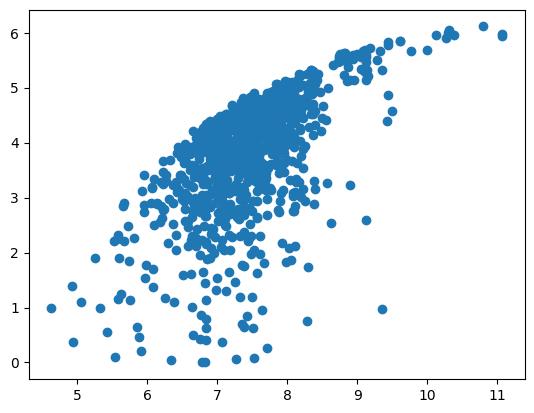

In [216]:

plt.scatter(ys, y_preds)

## Model global

In [14]:
d_tensor_1kg = torch.load("1kg-g2g-tensors.pt")
print(len(d_tensor_1kg))
list(d_tensor_1kg.items())[:5]

2535


[('NA18614', tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32)),
 ('HG01918', tensor([1, 1, 1,  ..., 1, 1, 2], dtype=torch.int32)),
 ('NA18546', tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32)),
 ('HG02855', tensor([1, 1, 1,  ..., 1, 2, 1], dtype=torch.int32)),
 ('HG03565', tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32))]

In [15]:
d_tensor_pcawg = torch.load("pcawg-g2g-tensors.pt")
print(len(d_tensor_pcawg))
list(d_tensor_pcawg.items())[:5]

142


[('FI26317', tensor([1., 6., 6.,  ..., 8., 2., 1.])),
 ('FI22889', tensor([10., 12.,  5.,  ...,  9.,  2.,  1.])),
 ('FI45246', tensor([12., 11.,  8.,  ..., 19.,  8.,  1.])),
 ('FI19114', tensor([ 7.,  9., 10.,  ...,  7.,  9.,  5.])),
 ('FI45994', tensor([3., 5., 1.,  ..., 1., 1., 1.]))]

In [16]:
d_tensor_global = d_tensor_1kg.copy()
d_tensor_global.update(d_tensor_pcawg)
print(len(d_tensor_global))
print(d_tensor_global['FI10093'][0:5], d_tensor_global['HG00096'][0:5])

2677
tensor([ 3.,  5., 13.,  4.,  5.]) tensor([1, 1, 1, 1, 1], dtype=torch.int32)


In [17]:
# set tensor to float 32
for k,v in d_tensor_global.items():
    d_tensor_global[k] = v.to(torch.float32)

In [18]:
df_target_global = pd.read_csv("global-g2g_l2.tsv", sep="\t")
print(df_target_global.shape)
df_target_global.head()

(3581826, 3)


l2      s_i      s_j
0  2099.0  NA18614  HG01918
1  2988.0  NA18614  NA18546
2  1381.0  NA18614  HG02855
3  1468.0  NA18614  HG03565
4  1244.0  NA18614  NA19324

<Axes: >

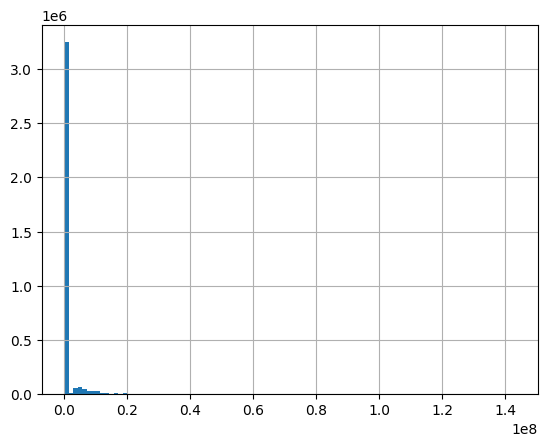

In [19]:
df_target_global['l2'].hist(bins=100)

- Note: standard scaler would center the targets around 0, however, I don't think it's straghtforward to z-score nomalize each embedding distance computed during training used to compute loss. There's probably a clever or complex way to do this, but it's out of the scope of this project. 

       l2      s_i      s_j    l2_log
0  2099.0  NA18614  HG01918  7.649693
1  2988.0  NA18614  NA18546  8.002694
2  1381.0  NA18614  HG02855  7.231287
3  1468.0  NA18614  HG03565  7.292337
4  1244.0  NA18614  NA19324  7.126891


Text(0.5, 1.0, 'Log l2 pairwise sqaured distances')

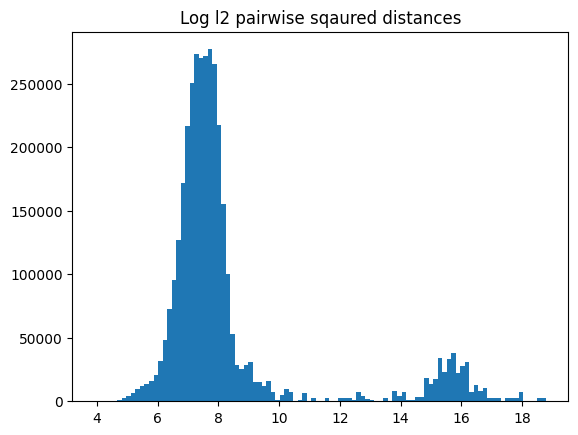

In [20]:
df_target_global['l2_log'] = df_target_global['l2'].apply(lambda x: np.log(x+1))
print(df_target_global.head())
df_target_global['l2_log'].hist(bins=100)
plt.grid(False)
plt.title('Log l2 pairwise sqaured distances')

### Split

In [22]:
# hold out 30% of samples from each population
p_samples_held_out = 0.3
n_held_out_1kg = int(np.floor(len(d_tensor_1kg) * p_samples_held_out))
n_held_out_pcawg = int(np.floor(len(d_tensor_pcawg) * p_samples_held_out))
print(n_held_out_1kg, n_held_out_pcawg)

760 42


In [23]:
random.seed(0)
test_samples_1kg = random.sample(list(d_tensor_1kg.keys()), n_held_out_1kg)
print(len(test_samples_1kg))
print(test_samples_1kg[:5])
test_samples_pcawg = random.sample(list(d_tensor_pcawg.keys()), n_held_out_pcawg)
print(len(test_samples_pcawg))
print(test_samples_pcawg[:5])

760
['HG03469', 'HG01527', 'HG03018', 'HG02595', 'HG03021']
42
['FI37278', 'FI34797', 'FI37071', 'FI16535', 'FI230']


In [24]:
test_samples_global = test_samples_1kg + test_samples_pcawg
print(len(test_samples_global))

802


In [25]:
# exclude test samples
df_target_global_tr = df_target_global[
    (~df_target_global['s_i'].isin(test_samples_global)) & (~df_target_global['s_j'].isin(test_samples_global))
]
print(len(df_target_global_tr))
# show that the test samples are not in the train set
print(
    pd.concat([df_target_global_tr['s_i'], df_target_global_tr['s_j']]).nunique(), # total samples in train
    len(test_samples_global), # total samples in test
    len(d_tensor_global)  # total samples
)
df_target_global_tr.head()

1756875
1875 802 2677


l2      s_i      s_j    l2_log
2534  3039.0  HG01918  NA18546  8.019613
2537  1209.0  HG01918  NA19324  7.098376
2539  1401.0  HG01918  NA19107  7.245655
2540  2259.0  HG01918  HG01162  7.723120
2542  2611.0  HG01918  NA21126  7.867871

In [26]:
# get test data
df_target_global_te = df_target_global[
    df_target_global['s_i'].isin(test_samples_global) | df_target_global['s_j'].isin(test_samples_global)
]
df_target_global_te.shape

(1824951, 4)

In [27]:
print(df_target_global.shape, df_target_global_tr.shape, df_target_global_te.shape)
print(df_target_global_tr.shape[0] + df_target_global_te.shape[0])

(3581826, 4) (1756875, 4) (1824951, 4)
3581826


Note:

- Train requires both (and) samples NOT to be in the test set
- Test requires either (or) sample to be in the test set

### Curriculum 1 (within pop)

- Learn within population distances

In [130]:
# curriculum1 requires a delineation of which population each sample pair
# belongs to: {1kg, pcawg, mixed}

In [28]:
def label_pair_pop(s1, s2):
    if s1 in d_tensor_1kg.keys() and s2 in d_tensor_1kg.keys():
        return '1kg'
    if s1 in d_tensor_pcawg.keys() and s2 in d_tensor_pcawg.keys():
        return 'pcawg'
    return 'mixed'
# examples
# 1kg
s1 = 'NA18614'
s2 = 'HG01918'
print(label_pair_pop(s1, s2))
# pcawg
s1 = 'FI22889'
s2 = 'FI35724'
print(label_pair_pop(s1,s2))
# mixed
s1 = 'NA19461'
s2 = 'FI35724'
print(label_pair_pop(s1,s2))
    

1kg
pcawg
mixed


In [29]:
df_target_global_tr['pop'] = df_target_global_tr.apply(lambda x: label_pair_pop(x['s_i'], x['s_j']), axis=1)
df_target_global_tr.head()

/tmp/ipykernel_6429/1683449697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target_global_tr['pop'] = df_target_global_tr.apply(lambda x: label_pair_pop(x['s_i'], x['s_j']), axis=1)


l2      s_i      s_j    l2_log  pop
2534  3039.0  HG01918  NA18546  8.019613  1kg
2537  1209.0  HG01918  NA19324  7.098376  1kg
2539  1401.0  HG01918  NA19107  7.245655  1kg
2540  2259.0  HG01918  HG01162  7.723120  1kg
2542  2611.0  HG01918  NA21126  7.867871  1kg

pop
1kg      1574425
mixed     177500
pcawg       4950
Name: count, dtype: int64


<Axes: xlabel='pop'>

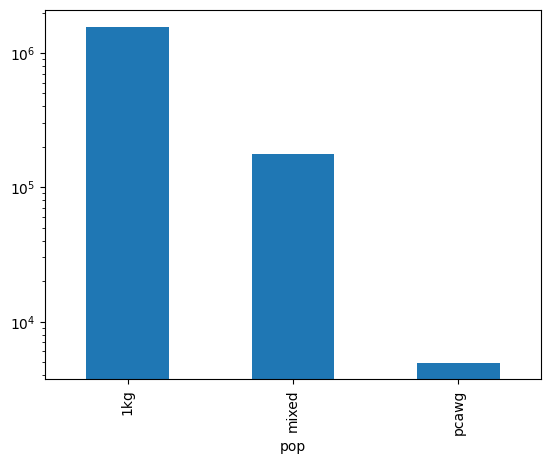

In [30]:
print(df_target_global_tr['pop'].value_counts())
df_target_global_tr['pop'].value_counts().plot(kind='bar', logy=True)

- Let's ensure that the model sees at a balanced amount of samples from each population in each batch

In [32]:
class SiameseDatasetC1(Dataset):
    def __init__(self, d_tensor, df_target, n_samples=1000, scaled_target=True):
        self.d_tensor = d_tensor
        self.df_target = df_target
        # n samples will define the total length of the dataset
        # we could insted use the length of the dataset (which is the number of samples)
        # len(d_tensor), but this is a lot of data per epoch
        # instead, a sampling pairs approach is used
        self.n_samples = n_samples
        self.scaled_target = scaled_target
        self.last_pop = None # track the population of latest pair

    def __len__(self):
        return self.n_samples
        # return len(d_tensor.items())

    def __getitem__(self, idx):
        # sample from the target dataframe
        # such that the population is the different from the last pair
        if self.last_pop is None: # random 1st pair
            pair = self.df_target.sample(1)
            self.last_pop = pair['pop'].values[0]
        elif self.last_pop == '1kg': # sample from pcawg
            pair = self.df_target[self.df_target['pop'] == 'pcawg'].sample(1)
            self.last_pop = pair['pop'].values[0]
        elif self.last_pop == 'pcawg': # sample from 1kg
            pair = self.df_target[self.df_target['pop'] == '1kg'].sample(1)
            self.last_pop = pair['pop'].values[0]
        else:
            raise ValueError("Invalid population")
        s1 = pair["s_i"].values[0]
        t1 = self.d_tensor[s1]
        s2 = pair["s_j"].values[0]
        t2 = self.d_tensor[s2]
        if self.scaled_target:
            target = torch.tensor(pair["l2_log"].values[0], dtype=torch.float32)
        else:
            target = torch.tensor(pair["l2"].values[0], dtype=torch.float32)
        return t1, t2, target

In [137]:
# dataset_c1 = SiameseDatasetC1(d_tensor_global, df_target_global_tr, n_samples=1000, scaled_target=True)
# next(iter(dataset_c1))
# print(dataset_c1.last_pop)
# next(iter(dataset_c1))
# print(dataset_c1.last_pop)
# next(iter(dataset_c1))
# print(dataset_c1.last_pop)
# next(iter(dataset_c1))
# print(dataset_c1.last_pop)
# print(next(iter(dataset_c1)))

In [33]:
dataset_c1 = SiameseDatasetC1(d_tensor_global, df_target_global_tr, n_samples=1000, scaled_target=True)
dataloader_c1 = DataLoader(dataset_c1, batch_size=256, shuffle=True)

In [38]:
input_dim = d_tensor_1kg["HG00096"].shape[0]
embedding_dim = 512
print(input_dim,embedding_dim)
model = SiameseNetwork(input_dim, embedding_dim)
model.to(device)
criterion = CustomMSELoss(scaled_target=False) # using log scaled l2
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 20

18721 512


In [39]:
torch.set_num_threads(15) # using gpu, but set this just in case
writer = SummaryWriter(log_dir="logs/c1")
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    l = []
    for i, data in enumerate(dataloader_c1):
        t1, t2, target = data
        t1, t2, target = t1.to(device), t2.to(device), target.to(device)
        # reset grad    
        optimizer.zero_grad()
        output1, output2 = model(t1, t2)
        embedding_distance = torch.sum((output1 - output2) ** 2, dim=1) # squared l2
        loss = criterion(embedding_distance, target)
        loss.backward()
        optimizer.step()
        l.append(loss.item())
        running_loss += loss.item()
        print(f"Epoch {epoch+1}, batch {i+1}, loss: {loss.item()}")
        writer.add_scalar('Loss/train', loss.item(), epoch * len(dataloader_c1) + i)
    print(f"Epoch {epoch+1}, loss: {running_loss}")
writer.close()

Epoch 1, batch 1, loss: 6180632.5
Epoch 1, batch 2, loss: 60833419264.0


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "siamese_c1_new.pt")

In [48]:
model = SiameseNetwork(input_dim, embedding_dim)
model.load_state_dict(torch.load("siamese_c1.pt"))
model.to(device)

SiameseNetwork(
  (fc): Sequential(
    (0): Linear(in_features=18721, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
  )
)

In [52]:
df_target_global_te_sub = df_target_global_te.sample(10000, random_state=0)
print(df_target_global_te_sub.shape)
df_target_global_te_sub.head()

(10000, 4)


l2      s_i      s_j     l2_log
788599       901.0  HG02870  NA18947   6.804615
3106155     1307.0  HG02089  HG00334   7.176255
520856       774.0  HG03871  NA18626   6.652863
3066720     1900.0  HG03729  HG02884   7.550135
3302155  2649503.0  NA18537  FI30911  14.789883

In [50]:
print(df_target_global_te.shape)

(1824951, 4)


In [54]:
# inference on test pairs
ys = []
y_preds = []
model.eval()
for i, row in df_target_global_te_sub.iterrows():
    s1 = row['s_i']
    s2 = row['s_j']
    t1 = d_tensor_global[s1].to(device)
    t2 = d_tensor_global[s2].to(device)
    output1, output2 = model(t1, t2)
    embedding_distance = torch.log10(torch.sum((output1 - output2) ** 2) + 1)
    y = row['l2_log']
    y_pred = embedding_distance.item()
    ys.append(y)
    y_preds.append(y_pred)
    print(f"Pair: {s1}, {s2}, target: {row['l2_log']}, distance: {embedding_distance.item()}")

Pair: HG02870, NA18947, target: 6.804614520062623, distance: 0.001015457441098988
Pair: HG02089, HG00334, target: 7.176254532017143, distance: 0.001764989923685789
Pair: HG03871, NA18626, target: 6.652863029353346, distance: 0.0007313872338272631
Pair: HG03729, HG02884, target: 7.550135342488429, distance: 0.003556779120117426
Pair: NA18537, FI30911, target: 14.789883010632629, distance: 1.8663254976272583
Pair: NA21113, FI30019, target: 15.53096351180748, distance: 1.9996299743652344
Pair: NA19042, HG01617, target: 7.3938782901077555, distance: 0.0014810999855399132
Pair: HG04063, NA20901, target: 6.720220155135295, distance: 0.0014147429028525949
Pair: HG00472, HG03428, target: 7.537962659768208, distance: 0.0012550520477816463
Pair: HG03965, HG00109, target: 9.711903228462988, distance: 0.06611254811286926
Pair: HG02733, HG01624, target: 7.77485576666552, distance: 0.004291074816137552
Pair: HG00684, HG02238, target: 7.362010551259734, distance: 0.0014482323313131928
Pair: NA19080, 

In [57]:
np.array(ys) - np.array(y_preds) 

array([ 6.80359906,  7.17448954,  6.65213164, ...,  7.27998883,
        7.61984993, 12.57575206])

In [58]:
# Compute the Mean Squared Error (MSE)
mse_siamese_c1 = np.mean((np.array(ys) - np.array(y_preds)) ** 2)
rmse_siamese_c1 = round(np.sqrt(mse_siamese_c1), 2)

print(f"Mean Squared Error: {mse_siamese_c1:.2f}")
print(f"log10(Mean Squared Error): {np.log10(mse_siamese_c1):.2f}")
print(f"Root Mean Squared Error: {rmse_siamese_c1}")
# print(f"Mean Squared Error: {mse_jl_eps_01:.2f}")
# print(f"log10(Mean Squared Error): {np.log10(mse_jl_eps_01):.2f}")
# print(f"Root Mean Squared Error: {rmse_jl_eps_01}")

Mean Squared Error: 70.38
log10(Mean Squared Error): 1.85
Root Mean Squared Error: 8.39


In [154]:
# compute embeddings for all samples in global df
c1_embeddings = []
index = []
for k,v in d_tensor_global.items():
    t = v.to(device)
    e = model.forward_one(t)
    index.append(k)
    c1_embeddings.append(e.cpu().detach().numpy())
df_c1_embeddings = pd.DataFrame(c1_embeddings)
df_c1_embeddings.index = index
df_c1_embeddings.head()

0         1         2         3         4         5         6    \
NA18614  0.014219  0.027213  0.072178  0.029255  0.047309  0.045635  0.031951   
HG01918  0.014127  0.024504  0.070981  0.028601  0.045705  0.045190  0.034703   
NA18546  0.015998  0.024767  0.077645  0.030433  0.048853  0.047572  0.032777   
HG02855  0.012336  0.029015  0.073515  0.028105  0.045317  0.040602  0.030779   
HG03565  0.013048  0.027831  0.070237  0.027979  0.045043  0.040536  0.032922   

              7         8         9    ...       502       503       504  \
NA18614  0.090546  0.030165 -0.025394  ... -0.054527  0.056184  0.031840   
HG01918  0.086800  0.032409 -0.024050  ... -0.054661  0.054443  0.033029   
NA18546  0.091679  0.032268 -0.016459  ... -0.063047  0.059349  0.033292   
HG02855  0.088841  0.033010 -0.025110  ... -0.051448  0.053601  0.035430   
HG03565  0.088000  0.032489 -0.025590  ... -0.051338  0.052197  0.033277   

              505       506       507       508       509       510       511  
NA18614 -0.031084 -0.042337 -0.077955 -0.190528 -0.036451  0.022287 -0.050690  
HG01918 -0.032609 -0.039989 -0.076226 -0.186768 -0.033745  0.020420 -0.049852  
NA18546 -0.028980 -0.042879 -0.076901 -0.196227 -0.040019  0.020811 -0.054597  
HG02855 -0.030885 -0.042076 -0.076600 -0.191332 -0.035685  0.018388 -0.050529  
HG03565 -0.031271 -0.042037 -0.075027 -0.188989 -0.033524  0.017458 -0.049533  

[5 rows x 512 columns]

In [ ]:
def tsne_contrastive(df1, df2,figtitle=None,  title1='tsne1', title2='tsne2', samples=None):
    # df 1
    tsne1 = TSNE(n_components=2, random_state=0)
    df_tsne1 = pd.DataFrame(tsne1.fit_transform(df1))
    df_tsne1.index = df1.index

    tsne2 = TSNE(n_components=2, random_state=0)
    df_tsne2 = pd.DataFrame(tsne2.fit_transform(df2))
    df_tsne2.index = df2.index

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].scatter(df_tsne1.iloc[:, 0], df_tsne1.iloc[:, 1], alpha=0.5)
    axes[0].set_title(title1)
    if samples:
        for i in samples:
            axes[0].scatter(
                df_tsne1.loc[i, 0], df_tsne1.loc[i, 1], color="red", s=50, label=i
            )
        # squared l2 distance
        d = np.linalg.norm(df1.loc[samples[0]] - df1.loc[samples[1]]) ** 2
        axes[0].set_title(f"{title1}\nSamples' squared L2 distance: {d:.2f}")
    axes[0].legend()

    # df 2
    axes[1].scatter(df_tsne2.iloc[:, 0], df_tsne2.iloc[:, 1], alpha=0.5)
    axes[1].set_title(title2)
    if samples:
        for i in samples:
            axes[1].scatter(
                df_tsne2.loc[i, 0], df_tsne2.loc[i, 1], color="red", s=50, label=i
            )
        # squared l2 distance
        d = np.linalg.norm(df2.loc[samples[0]] - df2.loc[samples[1]]) ** 2
        axes[1].set_title(f"{title2}\nSamples' squared L2 distance: {d:.2f}")
    axes[1].legend()
    if figtitle:
        fig.suptitle(figtitle)
# note: rmse is computed below
tsne_contrastive(df_global, df_c1_embeddings, title1='Original', title2='Siamese-C1, 512d')

### Curriculum 2 (between pop)

- Contrast populations

In [105]:
# curriculum2 dataset uses contrastive loss
# therefore, we need to sample triplets
# where the anchor and positive samples are from the same population
# for consistency and balancing, 
# the anchor and positive will definition will alternate for 
# batch construction
# e.g., anchor from 1kg, positive from 1kg, negative from 1kg (1kg is positive)
# e.g., anchor from pcawg, positive from pcawg, negative from 1kg (pcawg is positive)
# ... repeat this alternation
# essentially addressing class balance with dataset construction
class SiameseDatasetC2(Dataset):
    def __init__(self, d_tensor, df_target, n_samples=1000, scaled_target=True):
        self.d_tensor = d_tensor
        self.df_target = df_target
        # n samples will define the total length of the dataset
        # we could insted use the length of the dataset (which is the number of samples)
        # len(d_tensor), but this is a lot of data per epoch
        # instead, a sampling pairs approach is used
        self.n_samples = n_samples
        self.scaled_target = scaled_target
        self.last_positive = None # track which population was the positive in the last pair

    def __len__(self):
        return self.n_samples
        # return len(d_tensor.items())

    def __getitem__(self, idx):
        # sample from target dataframe
        # such that population is different from last pair
        # 'pairs' are positive and anchor
        if self.last_positive is None: # 1st pair is pcawg
            pair = self.df_target[self.df_target['pop']=='pcawg'].sample(1)
            # since this is a random sample 
            # and all pairwise combinations are equally likely
            # choosing i or j does not matter
            negative = self.df_target[self.df_target['pop']=='1kg'].sample(1)['s_i'].values[0]
            self.last_positive = 'pcawg'

        elif self.last_positive == '1kg': # pair pcawg
            pair = self.df_target[self.df_target['pop'] == 'pcawg'].sample(1)
            negative = self.df_target[self.df_target['pop']=='1kg'].sample(1)['s_i'].values[0]
            self.last_positive = 'pcawg'

        elif self.last_positive == 'pcawg': # pair 1kg
            pair = self.df_target[self.df_target['pop'] == '1kg'].sample(1)
            negative = self.df_target[self.df_target['pop']=='pcawg'].sample(1)['s_i'].values[0]
            self.last_positive = '1kg'
        else:
            raise ValueError("Invalid population")

        positive = pair["s_i"].values[0]
        t_pos = self.d_tensor[positive]
        anchor = pair["s_j"].values[0]
        t_anchor = self.d_tensor[anchor]
        t_negative = self.d_tensor[negative]
        if self.scaled_target:
            # df_target has combinations
            # need to check for both orders of positive and anchor
            d_pair = self.df_target[
                (self.df_target['s_i'] == positive) & (self.df_target['s_j'] == anchor) |
                (self.df_target['s_i'] == anchor) & (self.df_target['s_j'] == positive)
            ]['l2_log'].values[0]
            d_pair = torch.tensor(d_pair, dtype=torch.float32)
            d_negative = self.df_target[
                (self.df_target['s_i'] == anchor) & (self.df_target['s_j'] == negative) |
                (self.df_target['s_i'] == negative) & (self.df_target['s_j'] == anchor)
            ]['l2_log'].values[0]
            d_negative = torch.tensor(d_negative, dtype=torch.float32)
        else:
            d_pair = self.df_target[
                (self.df_target['s_i'] == positive) & (self.df_target['s_j'] == anchor) |
                (self.df_target['s_i'] == anchor) & (self.df_target['s_j'] == positive)
            ]['l2'].values[0]
            d_pair = torch.tensor(d_pair, dtype=torch.float32)
            d_negative = self.df_target[
                (self.df_target['s_i'] == anchor) & (self.df_target['s_j'] == negative) |
                (self.df_target['s_i'] == negative) & (self.df_target['s_j'] == anchor)
            ]['l2'].values[0]
            d_negative = torch.tensor(d_negative, dtype=torch.float32)
        # return t_anchor, t_pos, t_negative, d_pair, d_negative, anchor, positive, negative
        return t_anchor, t_pos, t_negative, d_pair, d_negative

In [122]:
dataset_c2 = SiameseDatasetC2(d_tensor_global, df_target_global_tr, n_samples=1000, scaled_target=True)
dataloader_c2 = DataLoader(dataset_c2, batch_size=4)

- The sampling for batch construction is taking far too long. let's define it ourselves

In [123]:
# seems to work
# add anchor, positive, negative to return of function to test this
# print(next(iter(dataset_c2)))
# print(next(iter(dataset_c2)))
# print(next(iter(dataset_c2)))

In [124]:
input_dim = d_tensor_1kg["HG00096"].shape[0]
embedding_dim = 512
print(input_dim,embedding_dim)
model = SiameseNetwork(input_dim, embedding_dim)
model.to(device)
criterion = TripletLoss() # using log scaled l2
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 1

18721 512


In [125]:
# takes about 10 m for 1 epoch with batch size 4
torch.set_num_threads(15) # using gpu, but set this just in case
writer = SummaryWriter(log_dir="logs/c2")
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    l = []
    for i, data in enumerate(dataloader_c2):
        anchor, pos, neg, d_pos, d_neg = data
        # anchor, pos, neg, d_pos, d_neg = next(iter(dataloader_c2))
        # print(anchor.shape, pos.shape, neg.shape, d_pos.shape, d_neg.shape)
        anchor, pos, neg, d_pos, d_neg = anchor.to(device), pos.to(device), neg.to(device), d_pos.to(device), d_neg.to(device)
        # reset grad    
        optimizer.zero_grad()
        # call forward on each
        output_anchor = model.forward_one(anchor)
        output_pos = model.forward_one(pos)
        output_neg = model.forward_one(neg)
        loss = criterion(output_anchor, output_pos, output_neg)
        loss.backward()
        optimizer.step()
        l.append(loss.item())
        running_loss += loss.item()
        print(f"Epoch {epoch+1}, batch {i+1}, loss: {loss.item()}")
        writer.add_scalar('Loss/train', loss.item(), epoch * len(dataloader_c2) + i)
    print(f"Epoch {epoch+1}, loss: {running_loss}")
writer.close()

Epoch 1, batch 1, loss: 0.712000846862793
Epoch 1, batch 2, loss: 0.9160346984863281
Epoch 1, batch 3, loss: 0.4985682964324951
Epoch 1, batch 4, loss: 0.0
Epoch 1, batch 5, loss: 0.0
Epoch 1, batch 6, loss: 0.0
Epoch 1, batch 7, loss: 0.07136626541614532
Epoch 1, batch 8, loss: 0.0
Epoch 1, batch 9, loss: 0.0
Epoch 1, batch 10, loss: 0.0
Epoch 1, batch 11, loss: 0.0
Epoch 1, batch 12, loss: 0.0
Epoch 1, batch 13, loss: 0.0
Epoch 1, batch 14, loss: 0.0
Epoch 1, batch 15, loss: 0.02096801996231079
Epoch 1, batch 16, loss: 0.0
Epoch 1, batch 17, loss: 0.0
Epoch 1, batch 18, loss: 0.0
Epoch 1, batch 19, loss: 0.0
Epoch 1, batch 20, loss: 0.0
Epoch 1, batch 21, loss: 0.0
Epoch 1, batch 22, loss: 0.0
Epoch 1, batch 23, loss: 0.0
Epoch 1, batch 24, loss: 0.0
Epoch 1, batch 25, loss: 0.0
Epoch 1, batch 26, loss: 0.0
Epoch 1, batch 27, loss: 0.0
Epoch 1, batch 28, loss: 0.0
Epoch 1, batch 29, loss: 0.21800440549850464
Epoch 1, batch 30, loss: 0.126941978931427
Epoch 1, batch 31, loss: 0.0
Epoc

In [126]:
# inference on test pairs
ys_c2 = []
y_preds_c2 = []
model.eval()
for i, row in df_target_global_te_sub.iterrows():
    s1 = row['s_i']
    s2 = row['s_j']
    t1 = d_tensor_global[s1].to(device)
    t2 = d_tensor_global[s2].to(device)
    output1, output2 = model(t1, t2)
    embedding_distance = torch.log10(torch.sum((output1 - output2) ** 2) + 1)
    y = row['l2_log']
    y_pred = embedding_distance.item()
    ys_c2.append(y)
    y_preds_c2.append(y_pred)
    print(f"Pair: {s1}, {s2}, target: {row['l2_log']}, distance: {embedding_distance.item()}")

Pair: HG02870, NA18947, target: 6.804614520062623, distance: 2.2919859886169434
Pair: HG02089, HG00334, target: 7.176254532017143, distance: 2.5086567401885986
Pair: HG03871, NA18626, target: 6.652863029353346, distance: 2.6609997749328613
Pair: HG03729, HG02884, target: 7.550135342488429, distance: 3.244628429412842
Pair: NA18537, FI30911, target: 14.789883010632629, distance: 8.80184268951416
Pair: NA21113, FI30019, target: 15.53096351180748, distance: 8.96792221069336
Pair: NA19042, HG01617, target: 7.3938782901077555, distance: 3.016040802001953
Pair: HG04063, NA20901, target: 6.720220155135295, distance: 2.5744588375091553
Pair: HG00472, HG03428, target: 7.537962659768208, distance: 3.269238233566284
Pair: HG03965, HG00109, target: 9.711903228462988, distance: 5.537421226501465
Pair: HG02733, HG01624, target: 7.77485576666552, distance: 3.6279165744781494
Pair: HG00684, HG02238, target: 7.362010551259734, distance: 1.416440725326538
Pair: NA19080, NA18907, target: 8.94663520890585

In [127]:
# Compute the Mean Squared Error (MSE)
mse_siamese_c2 = np.mean((np.array(ys_c2) - np.array(y_preds_c2)) ** 2)
rmse_siamese_c2 = round(np.sqrt(mse_siamese_c2), 2)

print(f"Mean Squared Error: {mse_siamese_c2:.2f}")
print(f"log10(Mean Squared Error): {np.log10(mse_siamese_c2):.2f}")
print(f"Root Mean Squared Error: {rmse_siamese_c2}")

Mean Squared Error: 23.85
log10(Mean Squared Error): 1.38
Root Mean Squared Error: 4.88


In [128]:
# compute embeddings for all samples in global df
c2_embeddings = []
index = []
for k,v in d_tensor_global.items():
    t = v.to(device)
    e = model.forward_one(t)
    index.append(k)
    c2_embeddings.append(e.cpu().detach().numpy())
df_c2_embeddings = pd.DataFrame(c2_embeddings)
df_c2_embeddings.index = index
df_c2_embeddings.head()

0          1          2          3          4           5    \
NA18614 -2.350965  85.091698  85.387283 -38.668812  90.502434 -131.554077   
HG01918 -2.276799  84.234070  84.442871 -38.135075  89.511314 -130.154327   
NA18546 -2.116066  82.873444  82.513901 -36.416080  87.677559 -128.102356   
HG02855 -2.557563  86.712349  87.416840 -40.472179  92.589821 -134.128128   
HG03565 -2.534371  86.603889  87.284958 -40.369473  92.480865 -133.965240   

               6          7          8          9    ...         502  \
NA18614 -34.723518 -45.419113 -55.638664  36.764709  ... -107.304436   
HG01918 -34.470772 -44.844185 -55.069599  36.461441  ... -106.128242   
NA18546 -34.813698 -43.236435 -54.630367  36.249775  ... -104.178398   
HG02855 -34.468750 -47.252136 -56.238388  36.892467  ... -109.574593   
HG03565 -34.511703 -47.136299 -56.201782  36.882488  ... -109.462189   

               503        504        505        506         507        508  \
NA18614 -69.615860 -44.852749 -63.347790  11.339028 -111.051949  63.842022   
HG01918 -68.802109 -44.389214 -62.913803  11.218188 -109.843994  63.046761   
NA18546 -67.210068 -43.840485 -64.137947  10.839460 -107.708466  60.670010   
HG02855 -71.441612 -45.612400 -62.231892  11.841010 -113.601013  66.476624   
HG03565 -71.327148 -45.550667 -62.297569  11.820086 -113.437790  66.316895   

               509         510        511  
NA18614  23.090393  128.378021 -84.586021  
HG01918  22.951553  127.177238 -83.743629  
NA18546  23.258219  126.293457 -82.937698  
HG02855  22.903496  129.608307 -85.923790  
HG03565  22.928192  129.545654 -85.853111  

[5 rows x 512 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


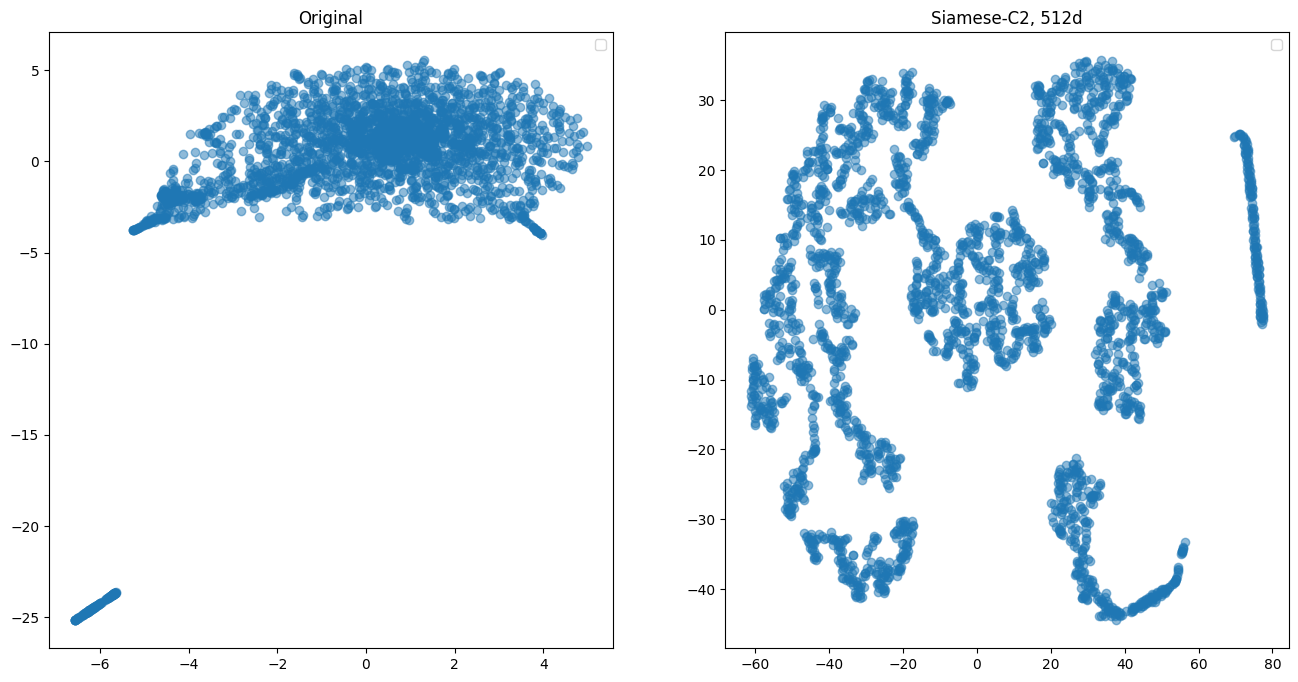

In [131]:
tsne_contrastive(df_global, df_c2_embeddings, title1='Original', title2='Siamese-C2, 512d')

In [ ]:
torch.save(model.state_dict(), "siamese_c2.pt")

### Curriculum 2-1
- Update the model trained on curriculum 2 by running curriulum 1

In [ ]:
# do curriculum 1 on model


In [133]:
dataset_c1 = SiameseDatasetC1(d_tensor_global, df_target_global_tr, n_samples=1000, scaled_target=True)
dataloader_c1 = DataLoader(dataset_c1, batch_size=256, shuffle=True)

In [134]:
input_dim = d_tensor_1kg["HG00096"].shape[0]
embedding_dim = 512
print(input_dim,embedding_dim)
# skip loading model
# model = SiameseNetwork(input_dim, embedding_dim)
# model.to(device)
criterion = CustomMSELoss(scaled_target=False) # using log scaled l2
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 20

18721 512


In [135]:
torch.set_num_threads(15) # using gpu, but set this just in case
writer = SummaryWriter(log_dir="logs/c2_1")
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    l = []
    for i, data in enumerate(dataloader_c1):
        t1, t2, target = data
        t1, t2, target = t1.to(device), t2.to(device), target.to(device)
        # reset grad    
        optimizer.zero_grad()
        output1, output2 = model(t1, t2)
        embedding_distance = torch.sum((output1 - output2) ** 2, dim=1) # squared l2
        loss = criterion(embedding_distance, target)
        loss.backward()
        optimizer.step()
        l.append(loss.item())
        running_loss += loss.item()
        print(f"Epoch {epoch+1}, batch {i+1}, loss: {loss.item()}")
        writer.add_scalar('Loss/train', loss.item(), epoch * len(dataloader_c1) + i)
    print(f"Epoch {epoch+1}, loss: {running_loss}")
writer.close()

Epoch 1, batch 1, loss: 8.79172521226666e+17
Epoch 1, batch 2, loss: 1.0254672505864192e+17
Epoch 1, batch 3, loss: 1.1496760941740032e+16
Epoch 1, batch 4, loss: 945362298732544.0
Epoch 1, loss: 9.941613695257805e+17
Epoch 2, batch 1, loss: 45311191941120.0
Epoch 2, batch 2, loss: 14812305162240.0
Epoch 2, batch 3, loss: 72508250259456.0
Epoch 2, batch 4, loss: 135908963647488.0
Epoch 2, loss: 268540711010304.0
Epoch 3, batch 1, loss: 179992315035648.0
Epoch 3, batch 2, loss: 163944874377216.0
Epoch 3, batch 3, loss: 132111289810944.0
Epoch 3, batch 4, loss: 316001178615808.0
Epoch 3, loss: 792049657839616.0
Epoch 4, batch 1, loss: 208529352818688.0
Epoch 4, batch 2, loss: 88526154629120.0
Epoch 4, batch 3, loss: 102151057571840.0
Epoch 4, batch 4, loss: 15288963694592.0
Epoch 4, loss: 414495528714240.0
Epoch 5, batch 1, loss: 21714081677312.0
Epoch 5, batch 2, loss: 14003208192000.0
Epoch 5, batch 3, loss: 7452024635392.0
Epoch 5, batch 4, loss: 9362468765696.0
Epoch 5, loss: 5253178

In [136]:
# inference on test pairs
ys_c2_1 = []
y_preds_c2_1 = []
model.eval()
for i, row in df_target_global_te_sub.iterrows():
    s1 = row['s_i']
    s2 = row['s_j']
    t1 = d_tensor_global[s1].to(device)
    t2 = d_tensor_global[s2].to(device)
    output1, output2 = model(t1, t2)
    embedding_distance = torch.log10(torch.sum((output1 - output2) ** 2) + 1)
    y = row['l2_log']
    y_pred = embedding_distance.item()
    ys_c2_1.append(y)
    y_preds_c2_1.append(y_pred)
    print(f"Pair: {s1}, {s2}, target: {row['l2_log']}, distance: {embedding_distance.item()}")

Pair: HG02870, NA18947, target: 6.804614520062623, distance: 0.07434621453285217
Pair: HG02089, HG00334, target: 7.176254532017143, distance: 0.20192934572696686
Pair: HG03871, NA18626, target: 6.652863029353346, distance: 0.4689885377883911
Pair: HG03729, HG02884, target: 7.550135342488429, distance: 0.744157075881958
Pair: NA18537, FI30911, target: 14.789883010632629, distance: 4.966798782348633
Pair: NA21113, FI30019, target: 15.53096351180748, distance: 5.168921947479248
Pair: NA19042, HG01617, target: 7.3938782901077555, distance: 0.8182306289672852
Pair: HG04063, NA20901, target: 6.720220155135295, distance: 0.5736629962921143
Pair: HG00472, HG03428, target: 7.537962659768208, distance: 0.6021958589553833
Pair: HG03965, HG00109, target: 9.711903228462988, distance: 2.5118935108184814
Pair: HG02733, HG01624, target: 7.77485576666552, distance: 0.8639034032821655
Pair: HG00684, HG02238, target: 7.362010551259734, distance: 0.07232586294412613
Pair: NA19080, NA18907, target: 8.94663

In [137]:
# Compute the Mean Squared Error (MSE)
mse_siamese_c2_1 = np.mean((np.array(ys_c2_1) - np.array(y_preds_c2_1)) ** 2)
rmse_siamese_c2_1 = round(np.sqrt(mse_siamese_c2_1), 2)

print(f"Mean Squared Error: {mse_siamese_c2_1:.2f}")
print(f"log10(Mean Squared Error): {np.log10(mse_siamese_c2_1):.2f}")
print(f"Root Mean Squared Error: {rmse_siamese_c2_1}")

Mean Squared Error: 53.23
log10(Mean Squared Error): 1.73
Root Mean Squared Error: 7.3


In [138]:
# compute embeddings for all samples in global df
c2_1_embeddings = []
index = []
for k,v in d_tensor_global.items():
    t = v.to(device)
    e = model.forward_one(t)
    index.append(k)
    c2_1_embeddings.append(e.cpu().detach().numpy())
df_c2_1_embeddings = pd.DataFrame(c2_1_embeddings)
df_c2_1_embeddings.index = index
df_c2_1_embeddings.head()

0         1         2         3         4         5         6    \
NA18614 -0.110437  4.913093  4.459377  1.634339 -1.198221 -6.100136  1.508166   
HG01918 -0.110998  4.892139  4.422693  1.622816 -1.200626 -6.049248  1.511835   
NA18546 -0.297725  4.961298  4.475075  1.589498 -1.284355 -6.157764  1.601599   
HG02855  0.125602  4.863725  4.528610  1.665993 -1.113187 -6.026205  1.423234   
HG03565  0.119014  4.866948  4.526727  1.662774 -1.127624 -6.031824  1.427105   

              7         8         9    ...       502       503       504  \
NA18614 -3.390940 -6.265541  3.579951  ...  4.506496 -2.518303 -1.407648   
HG01918 -3.356444 -6.220038  3.542803  ...  4.487460 -2.488842 -1.397912   
NA18546 -3.354927 -6.398140  3.555866  ...  4.571644 -2.463047 -1.435971   
HG02855 -3.479395 -6.154644  3.609099  ...  4.427052 -2.599090 -1.358617   
HG03565 -3.474864 -6.163694  3.604208  ...  4.439928 -2.596701 -1.362476   

              505       506       507       508       509       510       511  
NA18614 -4.524232 -0.995251  7.274682  1.529428  1.092031  1.323972  2.114827  
HG01918 -4.502656 -0.971937  7.222974  1.512779  1.116063  1.313962  2.113805  
NA18546 -4.587667 -1.025358  7.407110  1.535251  1.261024  1.385061  2.196522  
HG02855 -4.448276 -0.992897  7.089641  1.556182  0.984257  1.306608  1.979194  
HG03565 -4.458385 -0.994138  7.104330  1.566414  0.999774  1.303676  1.990299  

[5 rows x 512 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


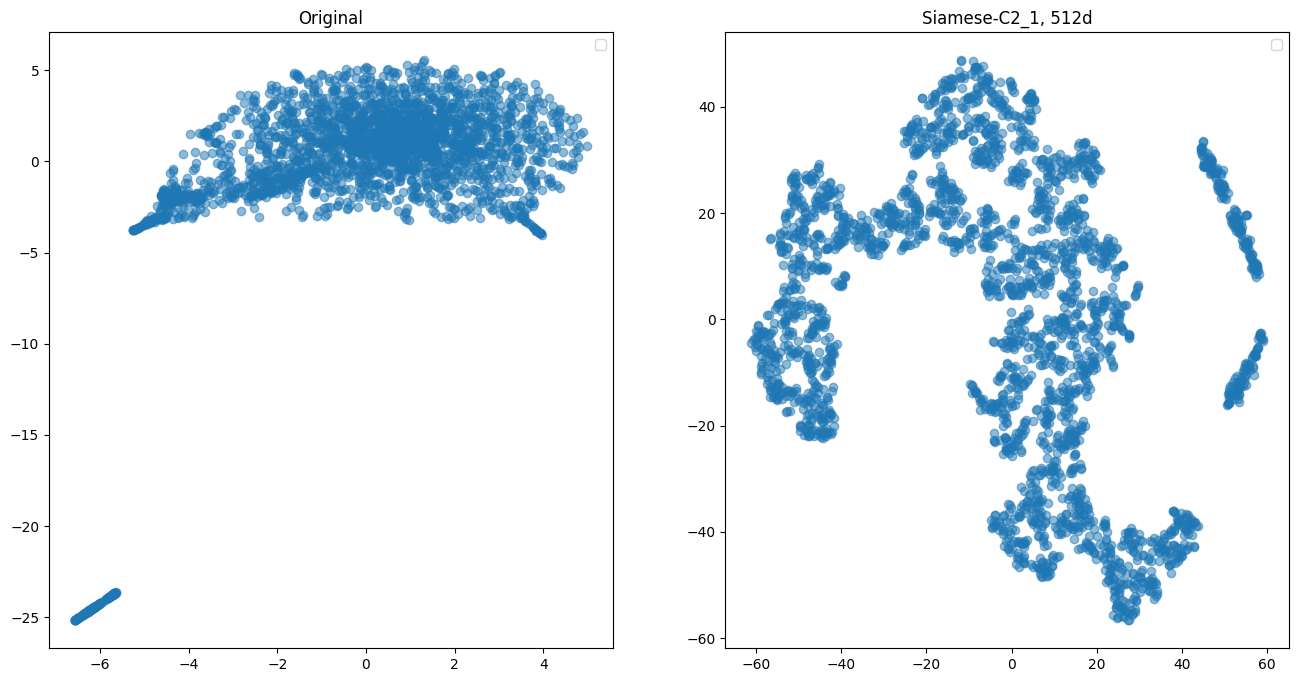

In [139]:
tsne_contrastive(df_global, df_c2_1_embeddings, title1='Original', title2='Siamese-C2_1, 512d')

In [141]:
torch.save(model.state_dict(), "siamese_c2_1.pt")

### Curriculum 1->2

In [152]:
model = SiameseNetwork(input_dim, embedding_dim)
model.load_state_dict(torch.load("siamese_c1.pt"))
model.to(device)

SiameseNetwork(
  (fc): Sequential(
    (0): Linear(in_features=18721, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
  )
)

In [153]:
dataset_c2 = SiameseDatasetC2(d_tensor_global, df_target_global_tr, n_samples=1000, scaled_target=True)
dataloader_c2 = DataLoader(dataset_c2, batch_size=4)

In [154]:
input_dim = d_tensor_1kg["HG00096"].shape[0]
embedding_dim = 512
print(input_dim,embedding_dim)
# model = SiameseNetwork(input_dim, embedding_dim)
# model.to(device)
criterion = TripletLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 1

18721 512


In [155]:
# takes about 15 m for 1 epoch with batch size 4
torch.set_num_threads(15) # using gpu, but set this just in case
writer = SummaryWriter(log_dir="logs/c1_2")
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    l = []
    for i, data in enumerate(dataloader_c2):
        anchor, pos, neg, d_pos, d_neg = data
        # anchor, pos, neg, d_pos, d_neg = next(iter(dataloader_c2))
        # print(anchor.shape, pos.shape, neg.shape, d_pos.shape, d_neg.shape)
        anchor, pos, neg, d_pos, d_neg = anchor.to(device), pos.to(device), neg.to(device), d_pos.to(device), d_neg.to(device)
        # reset grad    
        optimizer.zero_grad()
        # call forward on each
        output_anchor = model.forward_one(anchor)
        output_pos = model.forward_one(pos)
        output_neg = model.forward_one(neg)
        loss = criterion(output_anchor, output_pos, output_neg)
        loss.backward()
        optimizer.step()
        l.append(loss.item())
        running_loss += loss.item()
        print(f"Epoch {epoch+1}, batch {i+1}, loss: {loss.item()}")
        writer.add_scalar('Loss/train', loss.item(), epoch * len(dataloader_c2) + i)
    print(f"Epoch {epoch+1}, loss: {running_loss}")
writer.close()

Epoch 1, batch 1, loss: 0.8858987092971802
Epoch 1, batch 2, loss: 0.8887109756469727
Epoch 1, batch 3, loss: 0.6565307378768921
Epoch 1, batch 4, loss: 0.09974750876426697
Epoch 1, batch 5, loss: 0.0
Epoch 1, batch 6, loss: 0.0
Epoch 1, batch 7, loss: 0.0
Epoch 1, batch 8, loss: 0.0
Epoch 1, batch 9, loss: 0.0
Epoch 1, batch 10, loss: 0.0
Epoch 1, batch 11, loss: 0.0
Epoch 1, batch 12, loss: 0.0
Epoch 1, batch 13, loss: 0.0
Epoch 1, batch 14, loss: 0.0
Epoch 1, batch 15, loss: 0.0
Epoch 1, batch 16, loss: 0.0
Epoch 1, batch 17, loss: 0.31940126419067383
Epoch 1, batch 18, loss: 0.016209393739700317
Epoch 1, batch 19, loss: 0.0
Epoch 1, batch 20, loss: 0.0
Epoch 1, batch 21, loss: 0.20683740079402924
Epoch 1, batch 22, loss: 0.0
Epoch 1, batch 23, loss: 0.0
Epoch 1, batch 24, loss: 0.0
Epoch 1, batch 25, loss: 0.11047768592834473
Epoch 1, batch 26, loss: 0.0
Epoch 1, batch 27, loss: 0.0
Epoch 1, batch 28, loss: 0.0
Epoch 1, batch 29, loss: 0.10177476704120636
Epoch 1, batch 30, loss: 0

In [156]:
# inference on test pairs
ys_c1_2 = []
y_preds_c1_2 = []
model.eval()
for i, row in df_target_global_te_sub.iterrows():
    s1 = row['s_i']
    s2 = row['s_j']
    t1 = d_tensor_global[s1].to(device)
    t2 = d_tensor_global[s2].to(device)
    output1, output2 = model(t1, t2)
    embedding_distance = torch.log10(torch.sum((output1 - output2) ** 2) + 1)
    y = row['l2_log']
    y_pred = embedding_distance.item()
    ys_c1_2.append(y)
    y_preds_c1_2.append(y_pred)
    print(f"Pair: {s1}, {s2}, target: {row['l2_log']}, distance: {embedding_distance.item()}")

Pair: HG02870, NA18947, target: 6.804614520062623, distance: 0.10678182542324066
Pair: HG02089, HG00334, target: 7.176254532017143, distance: 0.16042403876781464
Pair: HG03871, NA18626, target: 6.652863029353346, distance: 0.19175361096858978
Pair: HG03729, HG02884, target: 7.550135342488429, distance: 0.457472026348114
Pair: NA18537, FI30911, target: 14.789883010632629, distance: 5.949870586395264
Pair: NA21113, FI30019, target: 15.53096351180748, distance: 6.141083240509033
Pair: NA19042, HG01617, target: 7.3938782901077555, distance: 0.4748818278312683
Pair: HG04063, NA20901, target: 6.720220155135295, distance: 0.2861207127571106
Pair: HG00472, HG03428, target: 7.537962659768208, distance: 0.29371780157089233
Pair: HG03965, HG00109, target: 9.711903228462988, distance: 2.72908616065979
Pair: HG02733, HG01624, target: 7.77485576666552, distance: 0.6861151456832886
Pair: HG00684, HG02238, target: 7.362010551259734, distance: 0.07340129464864731
Pair: NA19080, NA18907, target: 8.94663

In [157]:
# Compute the Mean Squared Error (MSE)
mse_siamese_c1_2 = np.mean((np.array(ys_c1_2) - np.array(y_preds_c1_2)) ** 2)
rmse_siamese_c1_2 = round(np.sqrt(mse_siamese_c1_2), 2)

print(f"Mean Squared Error: {mse_siamese_c1_2:.2f}")
print(f"log10(Mean Squared Error): {np.log10(mse_siamese_c1_2):.2f}")
print(f"Root Mean Squared Error: {rmse_siamese_c1_2}")

Mean Squared Error: 53.30
log10(Mean Squared Error): 1.73
Root Mean Squared Error: 7.3


In [158]:
# compute embeddings for all samples in global df
c1_2_embeddings = []
index = []
for k,v in d_tensor_global.items():
    t = v.to(device)
    e = model.forward_one(t)
    index.append(k)
    c1_2_embeddings.append(e.cpu().detach().numpy())
df_c1_2_embeddings = pd.DataFrame(c1_2_embeddings)
df_c1_2_embeddings.index = index
df_c1_2_embeddings.head()

0         1         2         3         4         5         6    \
NA18614  1.267015  0.680945 -3.521528 -2.511755 -4.151093  4.060120 -4.707609   
HG01918  1.255477  0.671900 -3.499431 -2.492366 -4.114361  4.019543 -4.677573   
NA18546  1.283872  0.702994 -3.525149 -2.512611 -4.000751  3.911446 -4.635540   
HG02855  1.247178  0.653809 -3.497504 -2.494080 -4.261574  4.150051 -4.764472   
HG03565  1.250675  0.656507 -3.500277 -2.497229 -4.257900  4.149350 -4.764567   

              7         8         9    ...       502       503       504  \
NA18614 -2.159440  6.071826 -3.749156  ... -0.109657  6.530722  2.543695   
HG01918 -2.140456  6.022643 -3.729754  ... -0.114716  6.481791  2.534689   
NA18546 -2.156681  5.976706 -3.695058  ... -0.127540  6.448555  2.625994   
HG02855 -2.140376  6.112181 -3.784175  ... -0.097489  6.569573  2.481126   
HG03565 -2.144987  6.115082 -3.786130  ... -0.100422  6.572141  2.483397   

              505       506       507       508       509       510       511  
NA18614 -0.946826 -5.703826 -7.427737  2.960900  2.808633 -3.126271  3.679750  
HG01918 -0.952623 -5.663061 -7.380185  2.953081  2.790124 -3.107803  3.658305  
NA18546 -0.979294 -5.659305 -7.414372  3.085237  2.796852 -3.148431  3.690210  
HG02855 -0.907711 -5.712157 -7.408928  2.838125  2.809472 -3.087524  3.661214  
HG03565 -0.916318 -5.714849 -7.413784  2.847672  2.809299 -3.093471  3.665297  

[5 rows x 512 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


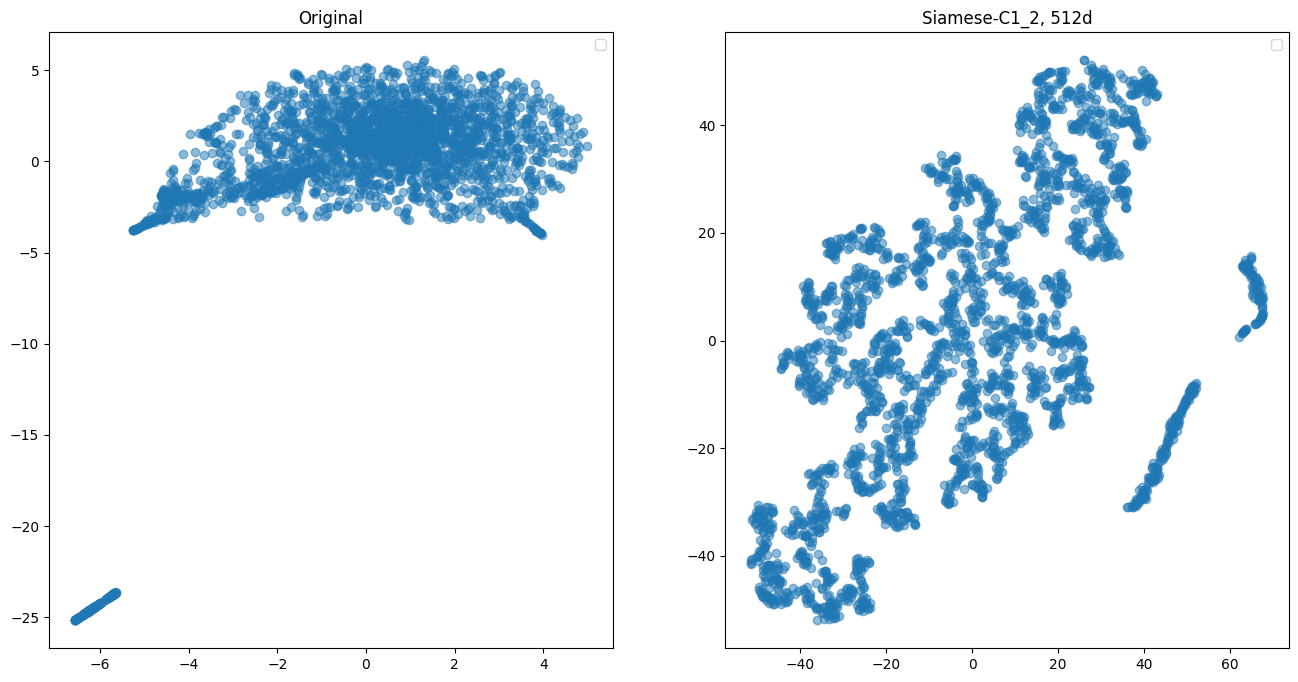

In [159]:
tsne_contrastive(df_global, df_c1_2_embeddings, title1='Original', title2='Siamese-C1_2, 512d')

## Misc

In [161]:
# save train and test targets
df_target_global_tr.to_csv("global-g2g_l2_train.tsv", sep="\t", index=False)
df_target_global_te_sub.to_csv("global-g2g_l2_test_sub.tsv", sep="\t", index=False)